In [19]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [20]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_dflow_grid_name, get_modflow_coupling_tag, get_modflow_grid_name

In [21]:
control_path = pl.Path("../dflow-fm/coarse/tides_2018/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_modflow_bathy2_net


In [22]:
# # BNB note, can this b changed to PJ model name?
# mf_grid_name = get_modflow_grid_name()
# print(mf_grid_name)

In [23]:
get_modflow_coupling_tag(1.)

'01.00H'

## Read the D-Flow FM output file

Make sure you run D-Flow FM by itself first so that there is an output NetCDF file available so that the mapping is done using the internal node order

In [24]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../dflow-fm/coarse/tides/FlowFM_map.nc"
source_ds = xugrid.open_dataset(source_path)

In [25]:
source_ds

<xarray.Dataset> Size: 3GB
Dimensions:                      (mesh2d_nNodes: 4917, mesh2d_nEdges: 13244,
                                  mesh2d_nFaces: 8323,
                                  mesh2d_nMax_face_nodes: 4, time: 2161)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 39kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 39kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 106kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 106kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 67kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 67kB ...
  * time                         (time) datetime64[ns] 17kB 2010-01-01 ... 20...
  * mesh2d_nNodes                (mesh2d_nNodes) int64 39kB 0 1 2 ... 4915 4916
  * mesh2d_nEdges                (mesh2d_nEdges) int64 106kB 0 1 ... 13242 13243
  * mesh2d_nFaces                (mesh2d_nFaces) int64 67kB 0 1 2 ... 8321 8322
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/24)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 39kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 266kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 106kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 67kB ...
    ...                           ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 229MB ...
    mesh2d_tausx                 (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_tausy                 (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 144MB ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 144MB ...
Attributes:
    institution:               Deltares
    references:                https://www.deltares.nl
    source:                    D-Flow FM 1.2.184.b981bf9c7329808883c693994582...
    history:                   Created on 2025-06-16T13:26:59-0400, D-Flow FM
    date_created:              2025-06-16T13:26:59-0400
    date_modified:             2025-06-16T13:26:59-0400
    Conventions:               CF-1.8 UGRID-1.0 Deltares-0.10 ACDD-1.3
    uuid:                      edb8f0d0-b651-e94c-b251-02ff34c8552d
    time_coverage_start:       2010-01-01T00:00:00+00:00
    time_coverage_end:         2010-04-01T00:00:00+00:00
    time_coverage_duration:    P90DT0H0M0S
    time_coverage_resolution:  P0000-00-00T01:00:00

In [59]:
dflowdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(source_ds.mesh2d_node_x , source_ds.mesh2d_node_y), crs = 'EPSG:32618')
dflowdf.explore()

In [26]:
print(source_ds.grid.face_node_connectivity.shape)
source_ds.grid.face_node_connectivity

(8323, 4)


array([[   1,    2,    0, -999],
       [   1,    0,    3, -999],
       [   4,    2,    1, -999],
       ...,
       [4845, 4844, 4846, -999],
       [4845, 4846, 4847, -999],
       [4847, 4846, 4916, -999]], dtype=int64)

In [27]:
print(source_ds.grid.node_face_connectivity.shape)
source_ds.grid.node_face_connectivity

(4917, 8323)


<4917x8323 sparse matrix of type '<class 'numpy.int32'>'
	with 25730 stored elements in Compressed Sparse Row format>

### Convert the NetCDF data to a geodataframe

In [28]:
source_gdf = source_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")

In [29]:
source_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry
mesh2d_nFaces,,,,
0,0,797792.521183,4.586474e+06,"POLYGON ((796131.574 4587170.597, 797777.440 4..."
1,1,797860.277210,4.587935e+06,"POLYGON ((796131.574 4587170.597, 799510.824 4..."
2,2,796310.449179,4.585497e+06,"POLYGON ((795089.014 4584339.408, 797777.440 4..."
3,3,799141.332451,4.585475e+06,"POLYGON ((797777.440 4584672.393, 800555.306 4..."
4,4,796489.440234,4.584052e+06,"POLYGON ((795089.014 4584339.408, 796588.120 4..."
...,...,...,...,...
8318,8318,580457.554636,4.524681e+06,"POLYGON ((579415.246 4525870.803, 580504.460 4..."
8319,8319,580388.824822,4.526572e+06,"POLYGON ((579415.246 4525870.803, 581410.744 4..."
8320,8320,581328.842310,4.527298e+06,"POLYGON ((580038.350 4527719.397, 581410.744 4..."


## Open the shapefile with the location of the coastal boundaries in MODFLOW

The shapefile needs to be limited to coastal boundary locations and be in the same coordinate system as the D-Flow FM model (UTM 18N).

In [30]:
fpth = f"../modflow/gis/PJ/PJ_coast_utm18n.shp"
print(fpth)

../modflow/gis/PJ/PJ_coast_utm18n.shp


In [31]:
target_coastal = gpd.read_file(fpth) # this is the shapefile with coastal boundary conditions
target_coastal
check = target_coastal[target_coastal['ghb_no'].notna()]

In [32]:
target_coastal.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

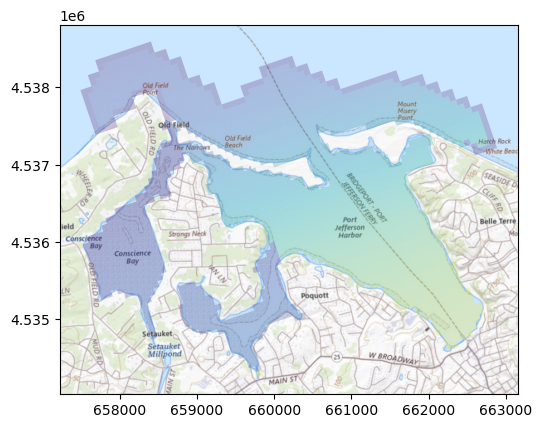

In [33]:
ax = target_coastal.plot(alpha=0.25, column="bnd_no")
cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

## Create the D-FLOW FM to GHB mapping

In [54]:
target_coastal.explore('ghb_no')

In [35]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="ghb_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()
weights['ghb_no'] = weights['ghb_no'].astype(float)

Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0259 seconds
Intersections finished in 0.0183 seconds
Weight gen finished in 0.0451 seconds


,ghb_no,cell,wght
0,0.0,5862,1.000000
1,1.0,5804,0.175140
2,1.0,5862,0.824860
3,2.0,5863,0.337611
4,2.0,5804,0.662389
...,...,...,...
282,324.0,5697,0.036464
283,325.0,5697,0.760069
284,326.0,5697,1.000000
285,334.0,5697,0.809759


In [36]:
weight_gen

In [37]:
weights[:12]
len(weights)

# bnb note - why 287 ? shouldn't it be 354?

287

In [38]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(1816, 8323)

In [39]:
dflow2mfghb = np.zeros(map_shape, dtype=float)
print(f"{dflow2mfghb.shape}\n{dflow2mfghb}")

(1816, 8323)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [40]:
weights

,ghb_no,cell,wght
0,0.0,5862,1.000000
1,1.0,5804,0.175140
2,1.0,5862,0.824860
3,2.0,5863,0.337611
4,2.0,5804,0.662389
...,...,...,...
282,324.0,5697,0.036464
283,325.0,5697,0.760069
284,326.0,5697,1.000000
285,334.0,5697,0.809759


In [41]:
for r,c,v in zip(weights["ghb_no"], weights["cell"], weights["wght"]):
    print(r,c,v)
    dflow2mfghb[int(r),int(c)] = v

0.0 5862 1.0000000000000002
1.0 5804 0.17514008949069948
1.0 5862 0.8248599105097625
2.0 5863 0.33761066151206043
2.0 5804 0.6623893384889417
3.0 5804 1.0000000000000002
4.0 5804 1.0000000000000002
5.0 5863 1.0
6.0 5863 0.6405491264331307
6.0 5804 0.3594508735676788
7.0 5804 1.0
8.0 5804 0.9999999999999999
9.0 5863 0.9617052276522341
9.0 5921 0.038294772350805265
10.0 5863 1.0
11.0 5863 0.9286055480447717
11.0 5804 0.07139445195496982
12.0 5863 0.014882385893365348
12.0 5804 0.9851176141071954
13.0 5804 1.0
14.0 5863 1.0
15.0 5863 1.0000000000000002
16.0 5863 1.0
17.0 5863 0.2464269706841019
17.0 5804 0.7535730293169779
18.0 5804 0.9999999999999999
19.0 5863 1.0
20.0 5863 1.0000000000000002
21.0 5863 1.0
22.0 5863 1.0000000000000002
23.0 5863 0.5493663185572343
23.0 5804 0.4506336814425583
24.0 5863 0.9057124930483935
24.0 5921 0.09428750695107721
25.0 5863 1.0000000000000002
26.0 5863 0.9999999999999999
27.0 5863 0.9999999999999999
28.0 5863 0.5943829206337805
28.0 5921 0.405617079369

## Create the ghb masking array

Where the sums of the weights along a row are not equal to ~1.0

In [42]:
mask_idx = np.isclose(dflow2mfghb.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")

203
(1816,)
[ True  True  True ... False False False]


### Test the D-FLOW FM to GHB mapping

In [43]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = dflow2mfghb.dot(s)[mask_idx]
s.shape, dflow2mfghb.shape, h.shape

((8323,), (1816, 8323), (1816,))

In [44]:
print(f"{h.sum()}\n{h}")

3429.000000000011
[1. 1. 1. ... 2. 2. 2.]


#### Test with a nan

In [45]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.24631225 0.54371463 0.72889868 ... 0.47983705 0.46510423 0.99899973]


In [46]:
h = np.full(mask_idx.shape, 2.0)
h = dflow2mfghb.dot(s)
h.shape

(1816,)

In [47]:
print(f"{h.sum()}\n{h}")

140.26413383893617
[0.89793742 0.90414402 0.9068287  ... 0.         0.         0.        ]


## Create the GHB to Qext mapping

In [48]:
ghb2qext = np.transpose(dflow2mfghb.copy())

### Test the GHB to Qext mapping

In [49]:
q = np.full(ghb2qext.shape[1], 1.0)

In [50]:
qext = ghb2qext.dot(q)

In [51]:
print(f"{qext.sum()}\n{qext.shape}")

219.20515822190532
(8323,)


## Save the mapping arrays

In [52]:
mf_grid_name = 'PJmf6'

fpath = f"../mapping/PJ/dflow_{grid_name}_to_{mf_grid_name}_ghb.npz"
np.savez_compressed(fpath, dflow2mfghb=dflow2mfghb, ghbmask=mask_idx, ghb2qext=ghb2qext)

In [60]:
fpath

'../mapping/PJ/dflow_LIS_modflow_bathy2_net_to_PJmf6_ghb.npz'